
# Time Series Forecasting using Auto Arima

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# set font scale and style
plt.rcParams.update({'font.size': 18})

# stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date', 'summer_ind'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 11)


,fatality_rate,p_isev_Fatality,p_isev_Injury,p_isev_No Injury,conf_ind_head-on,conf_ind_not-head-on,c_vehs,c_hour,p_age,year,month
date,,,,,,,,,,,
1999-01-01,0.012911,163.0,164.0,89.0,152.0,281.0,2.042258,13.511338,35.239035,1999,1
1999-02-01,0.018163,196.0,176.0,97.0,139.0,343.0,2.006859,13.499924,35.102478,1999,2
1999-03-01,0.020982,219.0,250.0,122.0,149.0,469.0,2.028966,13.507759,34.717830,1999,3
1999-04-01,0.015418,190.0,154.0,83.0,82.0,356.0,2.041576,13.890340,34.662779,1999,4
1999-05-01,0.017953,266.0,248.0,99.0,114.0,523.0,2.037239,13.851641,34.548825,1999,5


##  Create a test  set
We must split the dataset into training and test (out-of-sample) set. We have chosen the test set as the last year's observations (i.e. 2017).


In [5]:
y = ts['fatality_rate']
N = len(y)

exog_variables = list(ts.drop('fatality_rate', axis=1).columns)
x_exog = ts[exog_variables]

# add seasonality variables
x_exog['yearly_seasonality'] = np.arange(N) % 365
x_exog['monthly_seasonality'] = np.arange(N) % 30
# x_exog['weekly_seasonality'] = np.arange(N) % 7

In [6]:
train_start, train_end = '1999-01-01','2014-12-01'
test_start, test_end = '2014-01-01', '2017-12-01'

x_train = x_exog[train_start: train_end]
y_train = y[train_start: train_end]

x_test = x_exog[test_start: test_end]
y_test = y[test_start: test_end]

## Standardization

In [7]:
# standardization
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

# pandas dataframe
x_train_df = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_df = pd.DataFrame(x_test_scaled, columns = x_test.columns)

## SARIMAX
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [8]:
# train sarimax from auto arima API
sarimax = pm.auto_arima(y_train_scaled, exogenous=x_train_df, max_p=4, max_q=4, D=1, m=12, 
                        test='adf', stepwise=True, suppress_warnings=True, error_action='ignore',
                        seasonal=True, random_state=42, trace=True, n_fits=20
                       )
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=144.680, Time=4.75 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=196.660, Time=0.34 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=173.616, Time=2.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=154.090, Time=2.85 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=194.660, Time=0.40 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=147.968, Time=4.09 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=175.200, Time=3.73 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=140.291, Time=7.21 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=152.686, Time=8.02 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=142.471, Time=10.62 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=139.232, Time=10.20 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=140.864, Time=8.69 sec
 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=135.930, Time=7.26 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=138.562, Time=6.40 sec
 ARIMA(1,0,2)(1,1,1)[12] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                 -47.965
Date:                            Sun, 17 Apr 2022   AIC                            135.930
Time:                                    06:58:37   BIC                            199.789
Sample:                                         0   HQIC                           161.822
                                            - 192                                         
Covariance Type:                              opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0022      0.007      0.312      0.755      -0.012       0.016
p_isev_Fatality         -0.5522      0.224     -2.469      0.014      -0.991      -0.114
p_isev_Injury           -0.3632      0.253     -1.436      0.151      -0.859       0.132
p_isev_No Injury        -0.1796      0.118     -1.526      0.127      -0.410       0.051
conf_ind_head-on         0.7954      0.161      4.935      0.000       0.479       1.111
conf_ind_not-head-on     2.2874      0.452      5.059      0.000       1.401       3.174
c_vehs                  -0.0562      0.021     -2.643      0.008      -0.098      -0.015
c_hour                   0.2162      0.064      3.377      0.001       0.091       0.342
p_age                    0.3812      0.142      2.684      0.007       0.103       0.660
year                     0.0930      0.000    373.842      0.000       0.093       0.094
month                  2.02e-06   1.52e-07     13.322      0.000    1.72e-06    2.32e-06
yearly_seasonality       0.0929      0.000    373.848      0.000       0.092       0.093
monthly_seasonality      0.0261      0.033      0.792      0.428      -0.039       0.091
ar.L1                    0.8986      0.097      9.275      0.000       0.709       1.088
ma.L1                   -0.5605      0.141     -3.970      0.000      -0.837      -0.284
ma.L2                   -0.1322      0.113     -1.173      0.241      -0.353       0.089
ar.S.L12                -0.6189      0.205     -3.015      0.003      -1.021      -0.217
ma.S.L12                 0.0540      0.251      0.215      0.830      -0.438       0.546
ma.S.L24                -0.7057      0.142     -4.960      0.000      -0.985      -0.427
sigma2                   0.0924      0.010      9.491      0.000       0.073       0.112
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                12.80
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.43
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.4e+18. Standard errors may be unstable.
"""

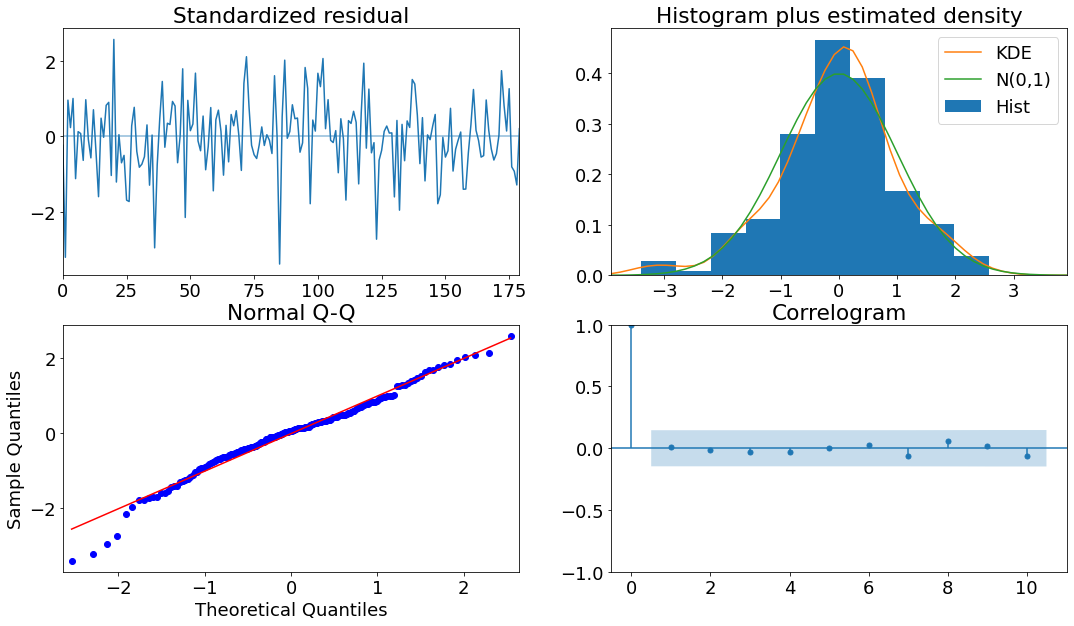

In [9]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

## Test (out-of-sample) prediction

In [10]:
y_pred, conf_int = sarimax.predict(n_periods=len(y_test), exogenous=x_test_df, return_conf_int=True)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten() # inverse transform scale

## Performance measures (error metrics)

In [11]:
fxn.error_metrics(y_test, y_pred)

{'MAE = 0.001', 'MAPE = 6.061', 'RMSE = 0.001', 'R^2 = 0.84', 'WMAPE = 5.235'}

In [12]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = scaler_y.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = scaler_y.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

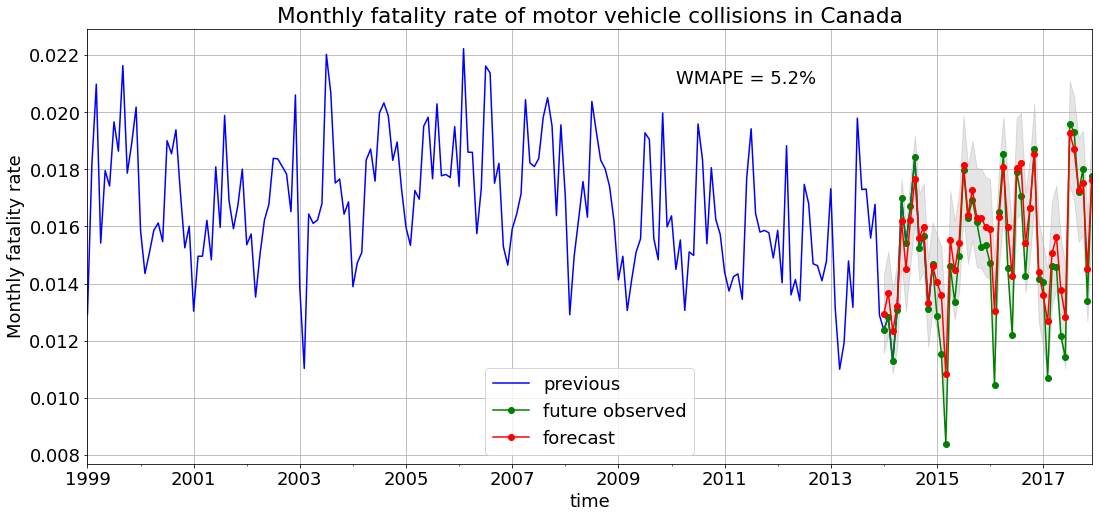

In [16]:
plt.figure(figsize = (18,8))

# y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_train.plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'r')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2010-02-01', 0.021, "WMAPE = 5.2%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly fatality rate of motor vehicle collisions in Canada')
plt.legend(loc = 'best')
plt.savefig('../images/fig_fcst.png')
plt.show()

## Model Diagnostics

## 1. Standadized residual of the test set 

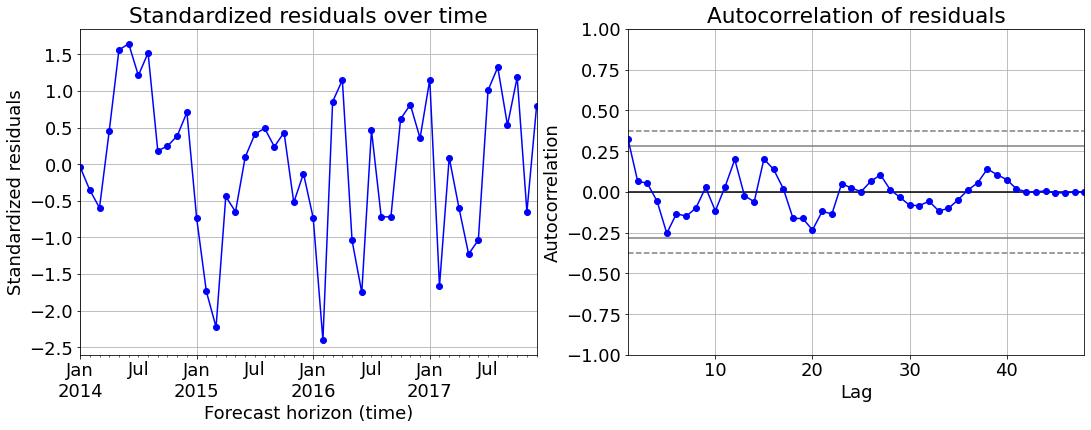

In [14]:
plt.figure(figsize = (18,6))
residual = y_test-results['y_pred']
rstandard = (residual-np.mean(residual))/np.std(residual)

plt.subplot(121)
rstandard.plot(color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (time)')
plt.ylabel('Standardized residuals')
plt.title('Standardized residuals over time')

plt.subplot(122)
pd.plotting.autocorrelation_plot(pd.Series(residual), color = 'b', marker = 'o')
plt.title('Autocorrelation of residuals')
plt.savefig('../images/figdi.png')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than 0.05 means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

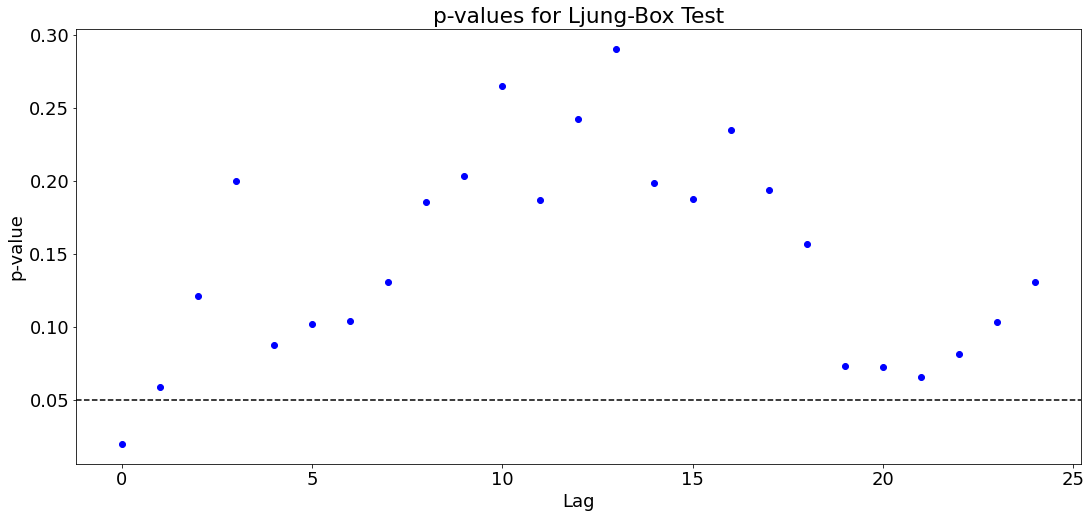

In [15]:
plt.figure(figsize = (18,8))
plt.plot(acorr_ljungbox(residual, lags = 25)[1], 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.title('p-values for Ljung-Box Test')
plt.savefig('../images/figlb.png')
plt.show()